# Lab 8: CNN Architectures
In this notebook we will explore standard CNN architectures using PyTorch and torchvision.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from torchsummary import summary

### Loading CIFAR10 Dataset

Since we are going to use networks that were pretrained on ImageNet, we need to normalize our data according to the mean and std with which these networks were trained, i.e. with the statistics of the ImageNet dataset.

In [2]:
# Normalize images
data_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)
print(f"Training size: {len(training_data)} \nValidation size: {len(validation_data)}")

100%|██████████| 170498071/170498071 [00:02<00:00, 69903462.63it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Training size: 50000 
Validation size: 10000


In [3]:
# get cpu or gpu device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


### Training loop

In [4]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          X, y = X.to(device), y.to(device)

          # Compute prediction error
          pred = model(X)
          loss = loss_fn(pred, y)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)
          preds.extend(final_pred.cpu().numpy())
          labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [5]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
  train_history = {'loss': [], 'accuracy': []}
  val_history = {'loss': [], 'accuracy': []}
  best_val_loss = np.inf
  print("Start training...")
  for t in range(num_epochs):
      print(f"\nEpoch {t+1}")
      train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
      print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
      val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
      print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

      # save model when val loss improves
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_name + '_best_model.pth')

      # save latest model
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, model_name + '_latest_model.pth')

      # save training history for plotting purposes
      train_history["loss"].append(train_loss)
      train_history["accuracy"].append(train_acc)

      val_history["loss"].append(val_loss)
      val_history["accuracy"].append(val_acc)

  print("Finished")
  return train_history, val_history

In [6]:
# Plot loss and accuracy during training
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### Custom CNN

Adapt custom CNN from last week to CIFAR10 data (32x32 colored images as input)

In [9]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(3, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(6272, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

custom_cnn = ConvolutionalNeuralNetwork()

custom_cnn.to(device)
print(custom_cnn)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


Start training...

Epoch 1


100%|██████████| 781/781 [00:16<00:00, 46.90it/s]


Train loss: 2.262 	 Train acc: 0.156


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 97%|█████████▋| 152/157 [00:02<00:00, 60.08it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 58.15it/s]


Val loss: 2.193 	 Val acc: 0.243

Epoch 2


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:14<00:00, 52.84it/s]


Train loss: 2.149 	 Train acc: 0.231


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 99%|█████████▊| 155/157 [00:02<00:00, 61.61it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 61.56it/s]


Val loss: 2.056 	 Val acc: 0.278

Epoch 3


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:14<00:00, 52.16it/s]


Train loss: 2.062 	 Train acc: 0.263


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 44.32it/s]


Val loss: 1.974 	 Val acc: 0.307

Epoch 4


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 50.73it/s]


Train loss: 1.995 	 Train acc: 0.290


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 59.10it/s]


Val loss: 1.908 	 Val acc: 0.336

Epoch 5


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 51.52it/s]


Train loss: 1.944 	 Train acc: 0.310


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Val loss: 1.858 	 Val acc: 0.355

Epoch 6


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 778/781 [00:15<00:00, 51.75it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 51.44it/s]


Train loss: 1.900 	 Train acc: 0.326


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 58.04it/s]


Val loss: 1.813 	 Val acc: 0.373

Epoch 7


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 51.84it/s]


Train loss: 1.862 	 Train acc: 0.341


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 59.80it/s]


Val loss: 1.770 	 Val acc: 0.387

Epoch 8


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 48.99it/s]


Train loss: 1.824 	 Train acc: 0.356


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 96%|█████████▌| 151/157 [00:02<00:00, 61.49it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 54.80it/s]


Val loss: 1.729 	 Val acc: 0.402

Epoch 9


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:14<00:00, 52.34it/s]


Train loss: 1.787 	 Train acc: 0.368


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:02<00:00, 57.78it/s]


Val loss: 1.687 	 Val acc: 0.416

Epoch 10


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:15<00:00, 49.99it/s]


Train loss: 1.751 	 Train acc: 0.381


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 42.27it/s]


Val loss: 1.654 	 Val acc: 0.425
Finished


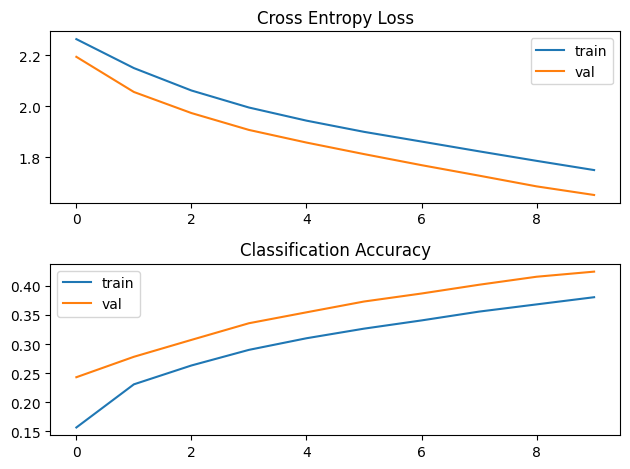

In [10]:
# Train network for 10 epochs
num_epochs = 10
model_name = 'custom CNN'

loss_fn = nn.CrossEntropyLoss()
optimizer_custom = torch.optim.SGD(custom_cnn.parameters(), lr=1e-3)

custom_train_history, custom_val_history = train(custom_cnn, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_custom)

plotTrainingHistory(custom_train_history, custom_val_history)

### 7x7 versus 3x3 Convolutions

Historically, the VGG was the first CNN architecture to introduce more layers (16-19 layers versus the 8 layers of AlexNet) and smaller convolutional kernel sizes (3x3).

This is mainly due to the fact that a stack of 3 3x3 convolutional layers (with stride 1) has the same effective receptive field as a single 7x7 layer. Why?

You can find out more about the effective receptive field of CNNs and explore some visualizations [here](https://blog.mlreview.com/a-guide-to-receptive-field-arithmetic-for-convolutional-neural-networks-e0f514068807).

Compare the number of parameters of a single convolutional layer with 7x7 kernel with a stack of 3 convolutional layers with 3x3 kernels.

In [ ]:
# TODO
# Use the summary method from the torchsummary package
# Compare one 7x7 convolution layer with three 3x3 layers
# Consider layers with only 1 input and output channels

What are the advantages of using a stack of 3 convolutional layers with 3x3 kernels instead of a single 7x7 layer?

## Pre-trained Models - VGG

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.9/models.html)


Load and adapt a VGG-16 model for the CIFAR10 data, through the following steps:
* Load the pre-trained VGG-16 model from torchvision
* Alter the output layer of the network to match the number of classes of the CIFAR10 data (10 classes)

In [18]:
# Load VGG model from torchvision (with pretrained=True)
import torchvision.models as models
vgg = models.vgg16(pretrained=True)

# Change the number of neurons in the last layer to the number of classes of the CIFAR10 dataset
num_classes = 10
in_features = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_features, num_classes)

vgg.to(device)

print(vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inspect the model structure.

What does the AdaptiveAvgPool2d layer do?

In [19]:
# Train network for 10 epochs
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)

Start training...

Epoch 1


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:38<00:00, 20.38it/s]


Train loss: 1.084 	 Train acc: 0.623


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:04<00:00, 34.80it/s]


Val loss: 0.731 	 Val acc: 0.745

Epoch 2


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|█████████▉| 780/781 [00:38<00:00, 20.49it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:38<00:00, 20.17it/s]


Train loss: 0.688 	 Train acc: 0.765


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 44.18it/s]


Val loss: 0.621 	 Val acc: 0.787

Epoch 3


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:39<00:00, 19.62it/s]


Train loss: 0.585 	 Train acc: 0.799


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 45.01it/s]


Val loss: 0.578 	 Val acc: 0.802

Epoch 4


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 781/781 [00:39<00:00, 19.87it/s]


Train loss: 0.517 	 Train acc: 0.822


  0%|          | 0/157 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 157/157 [00:03<00:00, 43.85it/s]


Val loss: 0.539 	 Val acc: 0.817

Epoch 5


  0%|          | 0/781 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 720/781 [00:36<00:03, 18.56it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
 92%|█████████▏| 720/781 [00:36<00:03, 19.86it/s]


KeyboardInterrupt: 

## Pre-trained Models - ResNet

[Click here to check the pre-trained models that are available on torchvision.](https://pytorch.org/vision/0.9/models.html)


Load and adapt a ResNet-50 model for the CIFAR10 data, through the following steps:
* Load the pre-trained VGG-50 model from torchvision
* Alter the output layer of the network to match the number of classes of the CIFAR10 data (10 classes)

In [ ]:
# Load ResNet model from torchvision (with pretrained=True)
resnet = # TODO

# Change the number of neurons in the last layer to the number of classes of the CIFAR10 dataset
# TODO

resnet.to(device)
print(resnet)

In [ ]:
# Train network for 10 epochs
num_epochs = 10
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss() # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

### Compare the VGG and ResNet models in terms of:


1.   number of parameters
2.   validation accuracy
3.   training time

What is the main difference introduced by the ResNet architecture?


In [ ]:
# TODO: use torchsummary to compare VGG-16 and ResNet-50

## Challenges

**Challenge 1:** In transfer learning, we often replace the head of the model (fully-connected layers responsible for classification) to fit the task. However, these new layers are not pre-trained and thus they contain an error that is backpropagated through the pre-trained part of the network during training. We can avoid this through a training strategy that is divided into two steps:
* Freeze the pre-trained layers of the network so that their parameters are no longer updated during training and train only the head of the model
* Unfreeze these layers and train the network as a whole.
Implement this strategy and see the results!

**Challenge 2:** Experiment with other CNN architectures available on torchvision.